In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
import os
import itertools
from collections import OrderedDict
import json

from meta_learning_analysis_plots import save

In [4]:
np.set_printoptions(linewidth=100)

In [5]:
MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

In [6]:
api = wandb.Api()

## Fetch the relevant runs from WandB

In [9]:
FULL_DATASET_PATTERN = 'meta-learning-scaling/sequential-benchmark/{run_id}'
FULL_DATASET_RUN_IDS = ('xk3ic9p7', 'lgkb14dn', '43wf5c4j', 'qq4mewef', 'i8o9tns8')


histories = [api.run(FULL_DATASET_PATTERN.format(run_id=run_id)).history(pandas=True)
             for run_id in FULL_DATASET_RUN_IDS]


In [25]:
print(histories[0].shape)
histories[0][:10]

(141, 95)


,Test AUC,Test Accuracy,Test Loss,Test Per-Query Accuracy (dict).0,Test Per-Query Accuracy (dict).1,Test Per-Query Accuracy (dict).10,Test Per-Query Accuracy (dict).11,Test Per-Query Accuracy (dict).12,Test Per-Query Accuracy (dict).13,Test Per-Query Accuracy (dict).14,...,gradients/fc1.bias,gradients/fc1.weight,gradients/fcout.fc2.bias,gradients/fcout.fc2.weight,gradients/fcout.fc3.bias,gradients/fcout.fc3.weight,gradients/fcout.fc4.bias,gradients/fcout.fc4.weight,gradients/fcout.fc5.bias,gradients/fcout.fc5.weight
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [4, 0, 3, 2, ...","{'bins': [-0.0007078171474859118, -0.000686200...","{'bins': [-3.4073571441695094e-05, -3.06374058...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [3, 1, 3, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 1, 0, 0, ..."
1,0.516887,54.79,0.684010,0.5378,0.5654,0.4910,0.5188,0.4758,0.5030,0.5780,...,"{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'bins': [-0.006817657500505447, -0.0066224099...","{'bins': [-0.0019140464719384909, -0.001858757...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'values': [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 2...","{'values': [1, 2, 1, 0, 2, 0, 1, 7, 9, 9, 16, ...","{'_type': 'histogram', 'values': [1, 2, 0, 0, ...","{'_type': 'histogram', 'values': [1, 3, 3, 2, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 2, 1, ..."
2,0.518163,55.52,0.685925,0.5464,0.5624,0.5068,0.5408,0.4944,0.5010,0.5946,...,"{'bins': [-0.02490227483212948, -0.02411620505...","{'_type': 'histogram', 'values': [4, 3, 3, 2, ...","{'_type': 'histogram', 'values': [2, 1, 1, 1, ...","{'bins': [-0.036345042288303375, -0.0345625244...","{'values': [1, 1, 1, 4, 4, 2, 6, 0, 1, 0, 1, 2...","{'bins': [-0.008250974118709564, -0.0079305432...","{'_type': 'histogram', 'values': [3, 1, 5, 4, ...","{'_type': 'histogram', 'values': [1, 1, 3, 4, ...","{'bins': [-0.0384378507733345, -0.037236668169...","{'_type': 'histogram', 'values': [3, 1, 4, 8, ..."
3,0.571805,59.56,0.628058,0.5462,0.5568,0.5328,0.6620,0.5964,0.5796,0.5980,...,"{'values': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'bins': [-0.03510168194770813, -0.03343043848...","{'_type': 'histogram', 'values': [2, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 1, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [4, 1, 3, 8, ..."
4,0.595458,61.67,0.597502,0.5510,0.5526,0.6360,0.6840,0.6100,0.5914,0.9514,...,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ...","{'_type': 'histogram', 'values': [1, 2, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 2, 1, 1, ...","{'_type': 'histogram', 'values': [8, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 2, ..."
5,0.635470,64.14,0.559530,0.5428,0.5494,0.9172,0.6850,0.6392,0.5960,0.9806,...,"{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 1, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 3, 2, ...","{'bins': [-0.020014390349388123, -0.0194889325...","{'bins': [-0.00407235324382782, -0.00396479154...","{'_type': 'histogram

## Old benchmark iterations behavior

In [411]:
def old_benchmark_iteration_plot(benchmark_histories, key_format, query_orders, super_title, ylims=None,
                               x_start=0, compute_x_max=False, font_dict=None, title_font_dict=None, save_path=None):
    if ylims is None:
        ylims = [None] * len(benchmark_histories)
    
    if font_dict is None:
        font_dict = {}
    
    if title_font_dict is None:
        title_font_dict = font_dict.copy()
    
    
    plt.figure(figsize=((PER_PLOT_WIDTH + 2) * len(benchmark_histories), 6))
    plt.subplots_adjust(top=0.9, hspace=0.25, wspace=0.2)
    plt.suptitle(super_title, fontsize=font_dict['fontsize'] * 1.5)
        
    x_max = None
    if compute_x_max:
        x_max = np.min([len(history[key_format.format(q=0)]) for history in model_histories])
    
    for model_index, (history, query_order) in enumerate(zip(benchmark_histories, query_orders)):
        ax = plt.subplot(1, len(benchmark_histories), model_index + 1)
        
        handles = []
    
        for i, q in enumerate(query_order):
            key = key_format.format(q=q)
            y_values = history[key][x_start:x_max] * 100
            x_values = np.arange(len(y_values)) + x_start + 1
            
            handles.extend(ax.plot(x_values, y_values, label=f'Query #{i + 1}'))
            
        if ylim is not None:
            ax.set_ylim(ylim)

        legend_font_dict = font_dict.copy()
        legend_font_dict['fontsize'] = legend_font_dict['fontsize'] - 8
        
        # Create a legend for the first half of the queryies
        first_legend = plt.legend(handles=handles[:5], loc='lower left', **legend_font_dict)

        # Add the legend manually to the current Axes.
        ax.add_artist(first_legend)

        # Create another legend for the second half of the queries
        plt.legend(handles=handles[5:], loc='lower right', **legend_font_dict)
        
        
        ax.set_xlabel('Epoch', **font_dict)
        ax.set_ylabel('Test accuracy', **font_dict)
#         ax.set_title(**title_font_dict)
    
    save(save_path)
    plt.show()
        

In [315]:
old_bechmark_histories = [api.run(FULL_DATASET_PATTERN.format(run_id=run_id)).history(pandas=True) 
                          for run_id in ('71v9mgax', '61np1dca')]

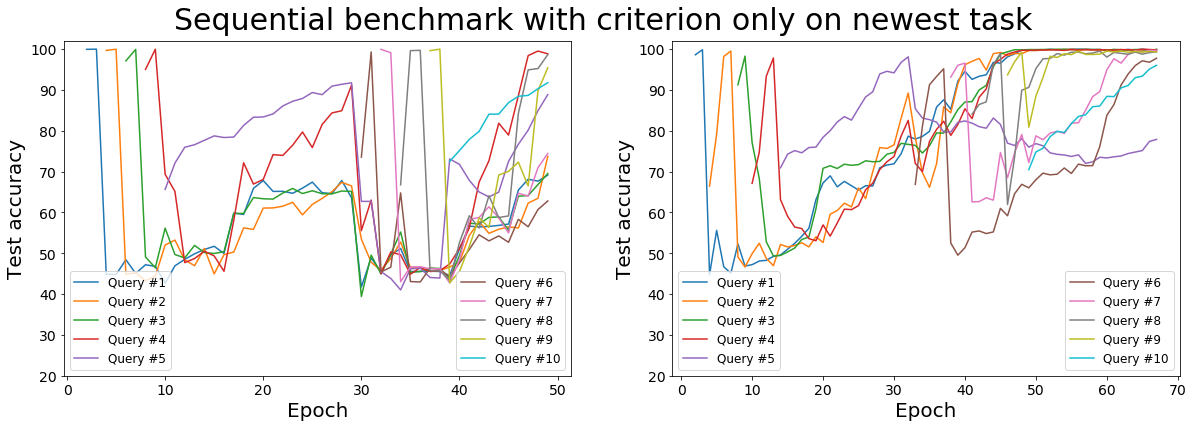

In [397]:
ylim = (20, 102)

old_benchmark_iteration_plot(old_bechmark_histories, 'Test accuracy, query = {q}', 
                             ([2, 8, 4, 9, 1, 6, 7, 3, 0, 5], [2, 8, 4, 9, 1, 6, 7, 3, 0, 5]), 'Sequential benchmark with criterion only on newest task',
                            font_dict=FONT_DICT, ylims=ylim, save_path='meta_learning/figures/benchmark/old_benchmark.png')

# Recreate some default WandB plots but with my formatting

In [412]:
DEFAULT_PAIRED_COLORMAP = 'Paired'


def modulate_color(color, amount=0.5):
    """
    Modulates the given color by multiplying (1-luminosity) by the given amount. 
    Amount < 1 lightens, while amount > 1 darkens
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Retrieved from: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def test_train_comparison_plot(model_histories, names, key_names, super_title, ylims=None,
                               x_start=0, compute_x_max=False, font_dict=None, title_font_dict=None,
                               colormap=DEFAULT_PAIRED_COLORMAP, save_path=None):
    if ylims is None:
        ylims = [None] * len(key_names)
    
    if font_dict is None:
        font_dict = {}
    
    if title_font_dict is None:
        title_font_dict = font_dict.copy()
    
    
    plt.figure(figsize=(PER_PLOT_WIDTH * len(key_names), 6))
    plt.subplots_adjust(top=0.825, hspace=0.25, wspace=0.2)
    plt.suptitle(super_title, fontsize=font_dict['fontsize'] * 1.5)
    
    colors = plt.get_cmap(colormap)
        
    x_max = None
    if compute_x_max:
        x_max = np.min([len(history[f'Train {key_names[0]}']) for history in model_histories])
    
    for index, (key_name, ylim) in enumerate(zip(key_names, ylims)):
        ax = plt.subplot(1, len(key_names), index + 1)
    
        for model_index, (name, history) in enumerate(zip(names, model_histories)):
            key = f'Train {key_name}'
            train_y_values = history[key][x_start:x_max]
            x_values = np.arange(len(train_y_values)) + x_start + 1
            
            ax.plot(x_values, train_y_values, color=modulate_color(colors(2 * model_index), 1.25), label=f'{name} {key}')
            
            key = f'Test {key_name}'
            test_y_values = history[key][x_start:x_max]
            
            ax.plot(x_values, test_y_values, color=colors(2 * model_index + 1), label=f'{name} {key}')
            
        if ylim is not None:
            ax.set_ylim(ylim)

        legend_font_dict = font_dict.copy()
        legend_font_dict['fontsize'] = legend_font_dict['fontsize'] - 6
        ax.legend(loc='best', **legend_font_dict)
        ax.set_xlabel('Epoch', **font_dict)
        ax.set_ylabel(key_name, **font_dict)
        ax.set_title(key_name, **title_font_dict)
        
    save(save_path)
    plt.show()


## Limited, initial dataset

In [399]:
limited_dataset_base_history = api.run('guy/meta-learning/qe6rpwk9').history(pandas=True) 

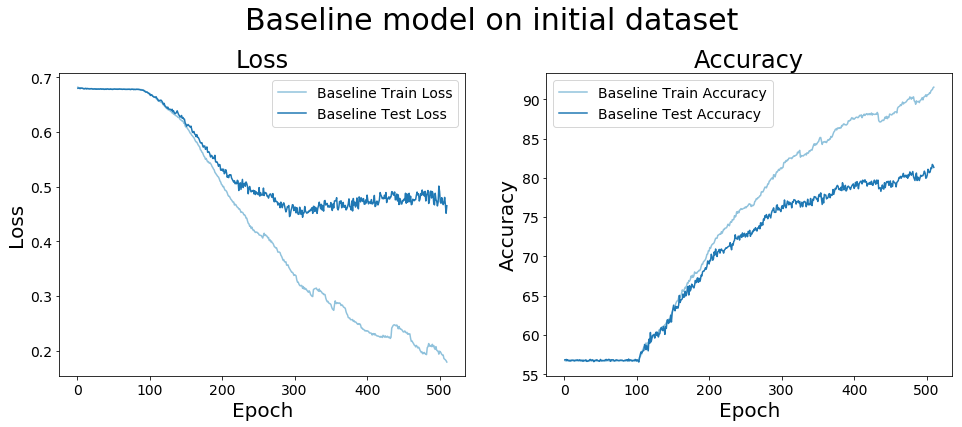

In [408]:
test_train_comparison_plot((limited_dataset_base_history, ), ('Baseline', ), ('Loss', 'Accuracy'), 'Baseline model on initial dataset', 
                            font_dict=FONT_DICT, title_font_dict=TITLE_FONT_DICT, colormap=DEFAULT_PAIRED_COLORMAP,
                           save_path='meta_learning/figures/baseline/initial_dataset.png')

## Full dataset, no anti-overfitting

In [300]:
full_dataset_base_history = api.run(FULL_DATASET_PATTERN.format(run_id='bckt4xx1')).history(pandas=True)

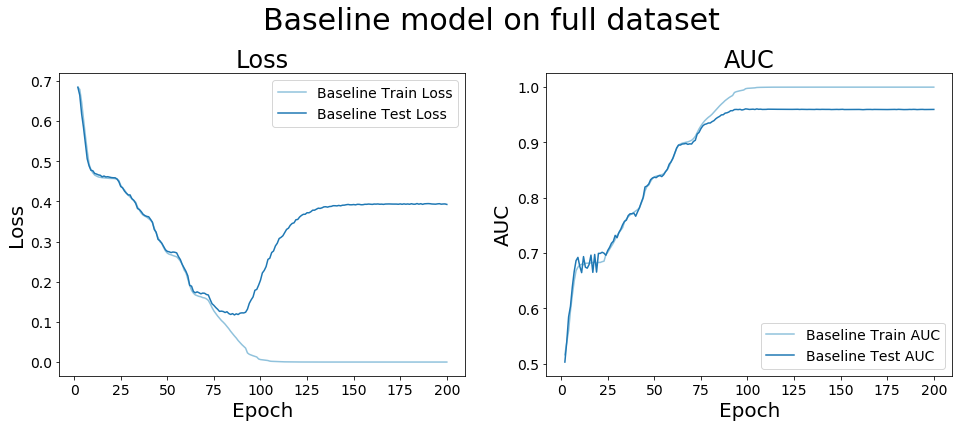

In [401]:
test_train_comparison_plot((full_dataset_base_history, ), ('Baseline', ), ('Loss', 'AUC'), 'Baseline model on full dataset', 
                            font_dict=FONT_DICT, title_font_dict=TITLE_FONT_DICT, colormap=DEFAULT_PAIRED_COLORMAP,
                           save_path='meta_learning/figures/baseline/full_dataset.png')

## With anti-overfitting measures

In [266]:
full_dataset_weight_decay_history = api.run(FULL_DATASET_PATTERN.format(run_id='elohyghn')).history(pandas=True)
full_dataset_dropout_history = api.run(FULL_DATASET_PATTERN.format(run_id='0de5ylqo')).history(pandas=True)

full_dataset_histories = (full_dataset_base_history, full_dataset_weight_decay_history, full_dataset_dropout_history)

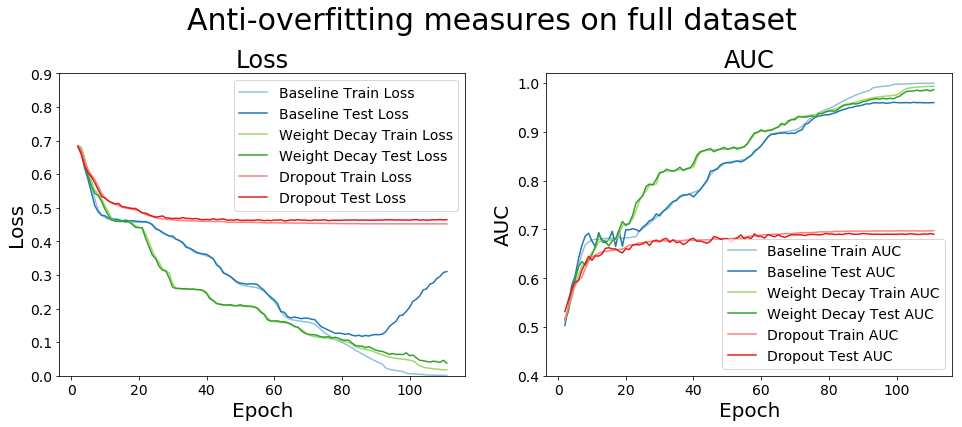

In [402]:
test_train_comparison_plot(full_dataset_histories, ('Baseline', 'Weight Decay', 'Dropout'), ('Loss', 'AUC'), 
                           'Anti-overfitting measures on full dataset', ylims=((0, 0.9), (0.4, 1.02)), compute_x_max=True,
                           font_dict=FONT_DICT, title_font_dict=TITLE_FONT_DICT, colormap=DEFAULT_PAIRED_COLORMAP,
                           save_path='meta_learning/figures/baseline/full_dataset_anti_overfitting.png')

## Plot the test accuracy and AUC for query-modulated models

In [433]:
NAMES = ['No query modulation'] + [f'Modulation level {d}' for d in range(1, 5)]

def multiple_comparison_plot(keys, titles, super_title, start_index=0, 
                             x_start=0, compute_x_max=False, font_dict=None, save_path=None):
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    plt.figure(figsize=(PER_PLOT_WIDTH * len(keys), 6))
    plt.subplots_adjust(top=0.825 - 0.05 * super_title.count('\n'), hspace=0.25, wspace=0.2)
    plt.suptitle(super_title, fontsize=font_dict['fontsize'] * 1.5)
        
    x_max = None
    if compute_x_max:
        x_max = np.min([len(history[keys[0]]) for history in histories])
    
    for index, (key, title) in enumerate(zip(keys, titles)):
        ax = plt.subplot(1, len(keys), index + 1)
    
        for name, history in zip(NAMES[start_index:], histories[start_index:]):
            y_values = history[key][x_start:x_max]
            x_values = np.arange(len(y_values)) + x_start + 1
            ax.plot(x_values, y_values, label=name)

        legend_font_dict = font_dict.copy()
        legend_font_dict['fontsize'] = legend_font_dict['fontsize'] - 4
        ax.legend(loc='best', **legend_font_dict)
        ax.set_xlabel('Epoch', **font_dict)
        ax.set_ylabel(key, **font_dict)
        ax.set_title(title)
        
    save(save_path)        
    plt.show()



Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/query_mod_simultaneous/baseline_comparison.png}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-query-mod-simultaneous-baseline-comparison}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/query_mod_simultaneous/baseline_comparison.png}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-query-mod-simultaneous-baseline-comparison}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



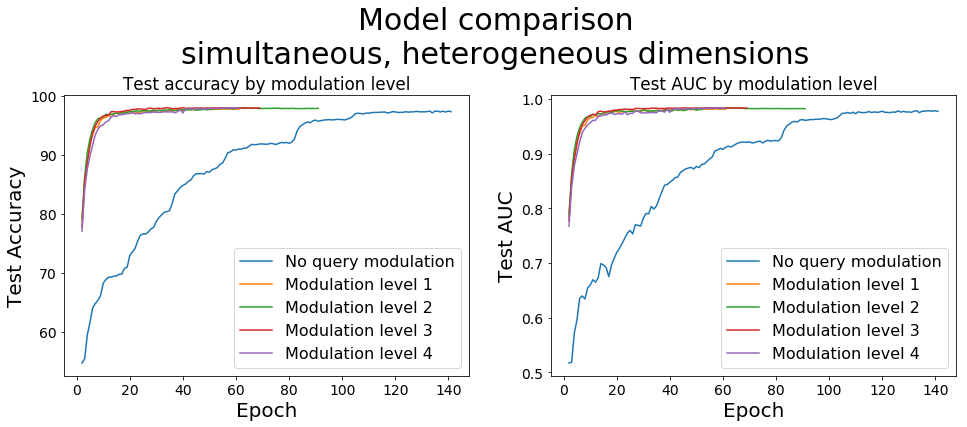

In [434]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                'Model comparison\nsimultaneous, heterogeneous dimensions',
                save_path='query_mod_simultaneous/baseline_comparison.png')


Looks like these models all learn much faster than the baseline model, but don't actually peak at a higher accuracy. Let's focus only on them to see if we can learn much:

Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/query_mod_simultaneous/query_mod_only.png}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-query-mod-simultaneous-query-mod-only}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/query_mod_simultaneous/query_mod_only.png}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-query-mod-simultaneous-query-mod-only}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



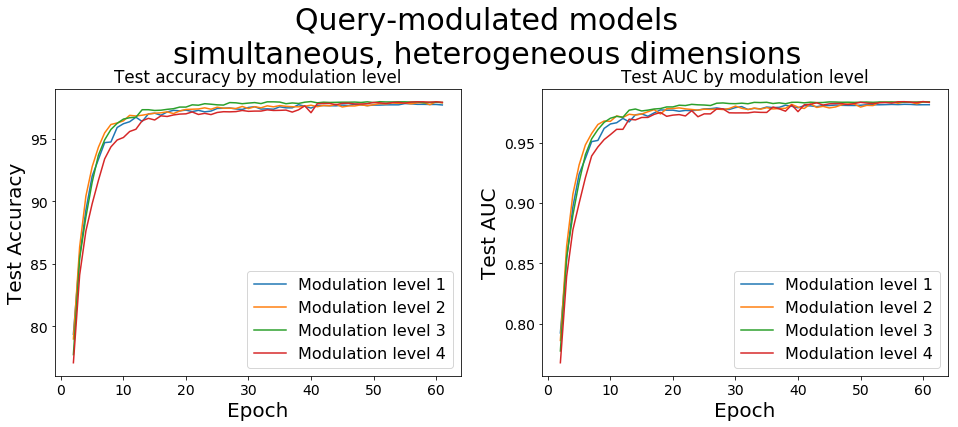

In [432]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                         ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                         'Query-modulated models\nsimultaneous, heterogeneous dimensions',
                         1, 0, True, save_path='query_mod_simultaneous/query_mod_only.png')


Looks like the third modulation level is a little bit better, but let's zoom in a little bit:

Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/query_mod_simultaneous/query_mod_zoomed.png}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-query-mod-simultaneous-query-mod-zoomed}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/query_mod_simultaneous/query_mod_zoomed.png}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-query-mod-simultaneous-query-mod-zoomed}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



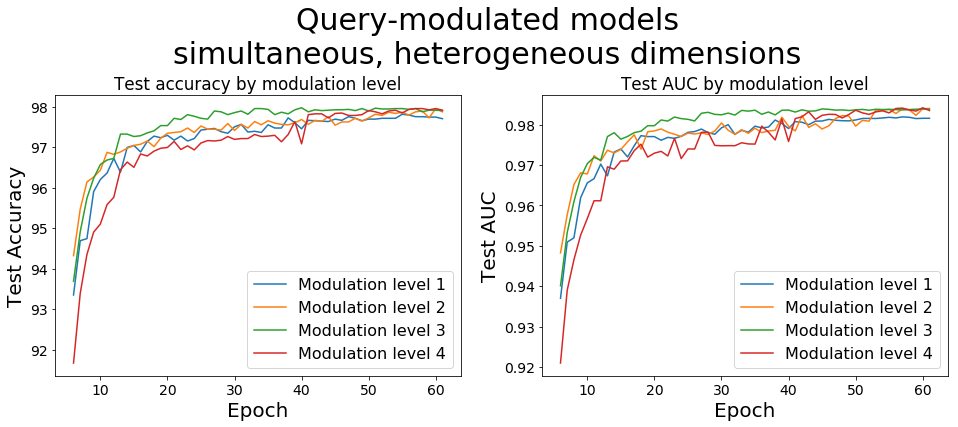

In [435]:
multiple_comparison_plot(('Test Accuracy', 'Test AUC'), 
                         ('Test accuracy by modulation level', 'Test AUC by modulation level'),
                         'Query-modulated models\nsimultaneous, heterogeneous dimensions',
                         1, 5, True, save_path='query_mod_simultaneous/query_mod_zoomed.png')


## Plotting accuracy by dimension, for each modulation level

In [406]:
QUERY_NAMES = ['blue', 'brown', 'cyan', 'gray', 'green', 'orange', 'pink',
               'purple', 'red', 'yellow', 'cone', 'cube', 'cylinder',
               'dodecahedron', 'ellipsoid', 'octahedron', 'pyramid', 'rectangle',
               'sphere', 'torus', 'chain_mail', 'marble', 'maze', 'metal',
               'metal_weave', 'polka', 'rubber', 'rug', 'tiles', 'wood_plank']
DIMENSION_NAMES = ['color', 'shape', 'texture']
KEY_TEMPLATE = 'Test Per-Query Accuracy (dict).{task_id}'

COLORS = dict(gray=(0.3411764705882353, 0.3411764705882353, 0.3411764705882353),
              red=(0.6784313725490196, 0.13725490196078433, 0.13725490196078433),
              blue=(0.16470588235294117, 0.29411764705882354, 0.8431372549019608),
              green=(0.11372549019607843, 0.4117647058823529, 0.0784313725490196),
              brown=(0.5058823529411764, 0.2901960784313726, 0.09803921568627451),
              purple=(0.5058823529411764, 0.14901960784313725, 0.7529411764705882),
              cyan=(0.1607843137254902, 0.8156862745098039, 0.8156862745098039),
              yellow=(1.0, 0.9333333333333333, 0.2),
              orange=(1.0, 0.5725490196078431, 0.2),
              pink=(1.0, 0.803921568627451, 0.9529411764705882))

In [391]:
NROWS = 5
NCOLS = 3

PER_COL_WIDTH = 8
PER_ROW_HEIGHT = 6

def plot_accuracy_by_dimension(histories, font_dict=None, ylim=None,
                               x_start=0, compute_x_max=False, colors=None, save_path=None):
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    plt.figure(figsize=(NCOLS * PER_COL_WIDTH, NROWS * PER_ROW_HEIGHT))
    plt.subplots_adjust(top=0.95, hspace=0.2, wspace=0.15)
    
    plt.suptitle('Accuracy per dimension by modulation level', fontsize=font_dict['fontsize'] * 1.5)
    
    x_max = None
    if compute_x_max:
        x_max = np.min([history.shape[0] for history in histories])
        
    for model_index, history in enumerate(histories):
        for dimension_index, dimension_name in enumerate(DIMENSION_NAMES):
            ax = plt.subplot(NROWS, NCOLS, model_index * NCOLS + dimension_index + 1)

            title = None
            if model_index == 0:
                title = dimension_name.capitalize()
                
            x_label = None
            if model_index == NROWS - 1:
                x_label = 'Epoch'
                
            y_label = None
            y_label_right = False
            if dimension_index == 0:
                y_label = 'Test Accuracy'
            elif dimension_index == 2:
                y_label_right = True
                if model_index == 0:
                    y_label = f'No query\nmodulation'
                else:
                    y_label = f'Query modulation\nat conv-{model_index}'
            
            # Use x_max only for the non-query-modulated models
            model_x_max = x_max
            if model_index == 0:
                model_x_max = None
                
            single_model_single_dimension_plot(ax, history,
                                               10 * dimension_index, 
                                               10 * (dimension_index + 1), 
                                               x_start, model_x_max, ylim, title, x_label, y_label, 
                                               font_dict, colors, y_label_right)
    
    save(save_path)
    
    plt.show()
    
    
def single_model_single_dimension_plot(ax, history,
                                       start_task, end_task, x_start=0, x_max=None, ylim=None,
                                        title=None, x_label=None, y_label=None,
                                          font_dict=None, colors=None, y_label_right=False):
    font = FONT_DICT.copy()
    if font_dict is not None:
        font.update(font_dict)
    font_dict = font
    
    sample_y_values = history[KEY_TEMPLATE.format(task_id=start_task)][x_start:x_max]
    x_values = np.arange(len(sample_y_values)) + x_start
    
    for index, task_id in enumerate(range(start_task, end_task)):
        color = None
        if colors is not None:
            if isinstance (colors, dict):
                color = colors[QUERY_NAMES[index % 10]]
            else:
                color = colors[index / 10]
        
        ax.plot(x_values, history[KEY_TEMPLATE.format(task_id=task_id)][x_start:x_max] * 100,
                label=QUERY_NAMES[task_id], color=color, alpha=0.8)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    legend_fontsize = font_dict['fontsize'] - 8
    ax.legend(loc='lower right', fontsize=legend_fontsize)
    if x_label is not None:
        ax.set_xlabel(x_label, **font_dict)
    if y_label is not None:
        ax.set_ylabel(y_label, **font_dict)
    if y_label_right:    
        ax.yaxis.set_label_position("right")
    if title is not None:
        ax.set_title(title, **font_dict)

Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/query_mod_simultaneous/query_mod_by_dimension.png}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-query-mod-simultaneous-query-mod-by-dimension}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/query_mod_simultaneous/query_mod_by_dimension.png}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-query-mod-simultaneous-query-mod-by-dimension}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



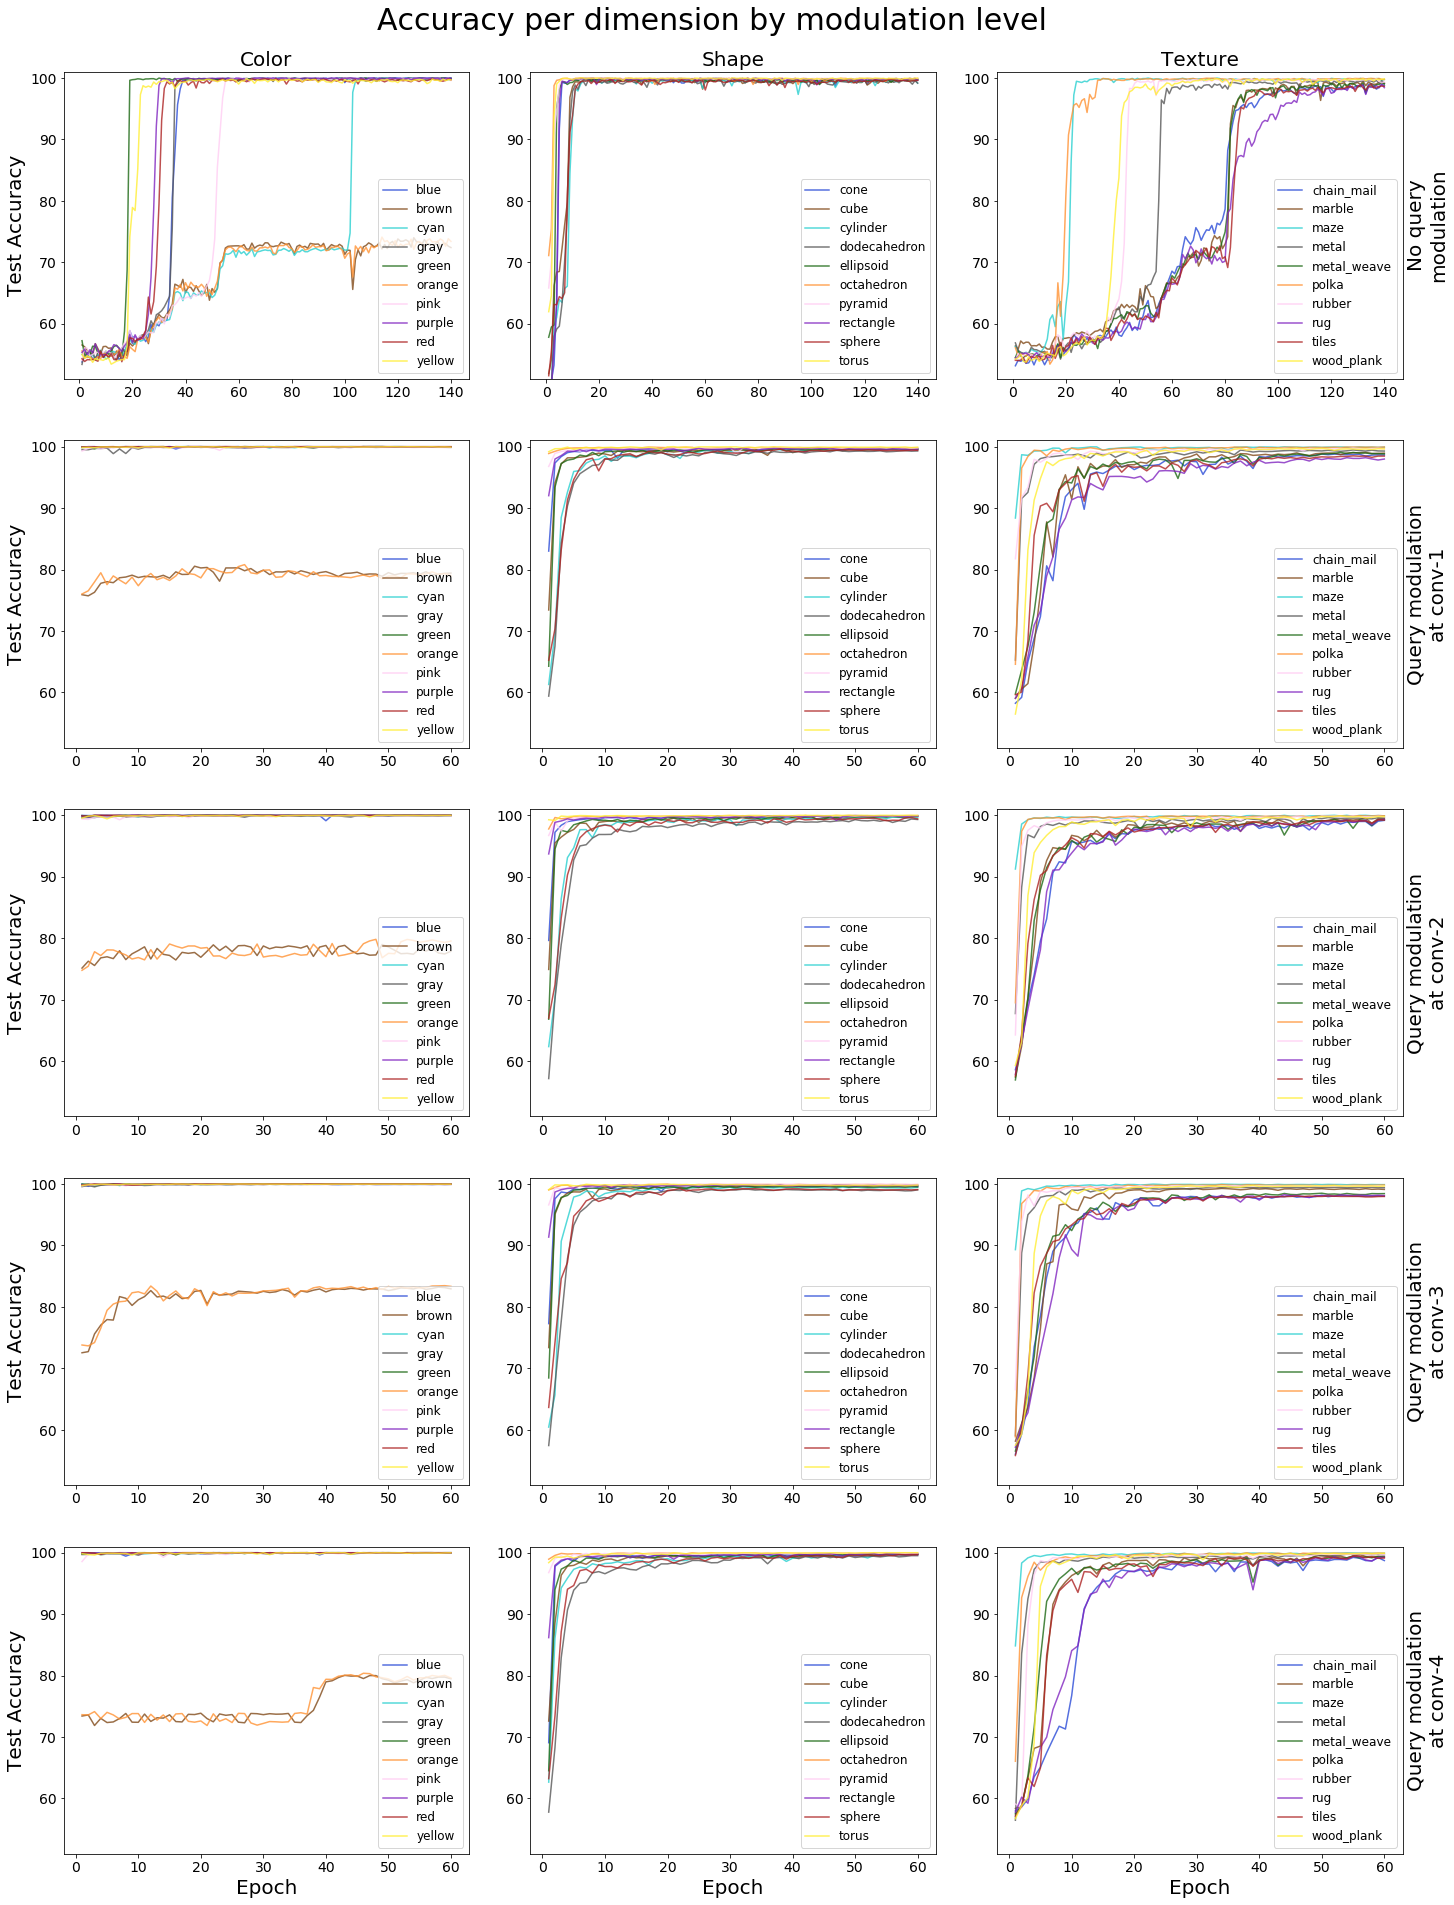

In [417]:
ylim = (51, 101)
plot_accuracy_by_dimension(histories, compute_x_max=True, ylim=ylim, colors=COLORS,
                           save_path='query_mod_simultaneous/query_mod_by_dimension.png')

--- 

# Check how many runs I saved checkpoints for

In [23]:
from collections import defaultdict

def count_saved_checkpoints(project_path):
    runs = api.runs(project_path)
    
    total = 0
    saved = 0
    dimension_counts = defaultdict(int)
    
    for r in runs:
        total += 1
        run_name = r.description.split('\n')[0]
        run_id = int(run_name[run_name.rfind('-') + 1:])
        try:
            files = r.files()
            if files is not None and len(files) > 0:
                file_names = [f.name for f in files]
                checkpoints_found = [any([fname.endswith(f'-query-{i}.pth') for fname in file_names])
                                     for i in range(10)]
                checkpoints_saved = int(all(checkpoints_found))
                # print(run_id, checkpoints_found, checkpoints_saved)
                saved += checkpoints_saved
                
                if checkpoints_saved:
                    print(r.name)
                    d = run_id // 1000
                    dimension_counts[d] += 1
                
        except:
            continue

    print(f'In project {project_path}, {saved} runs out of {total} ({saved / total * 100:.2f}%) have checkpoints')
    print(dimension_counts)

In [44]:
count_saved_checkpoints('meta-learning-scaling/sequential-benchmark-control')

In project meta-learning-scaling/sequential-benchmark-control, 114 runs out of 114 (100.00%) have checkpoints
defaultdict(<class 'int'>, {0: 114})


In [45]:
count_saved_checkpoints('meta-learning-scaling/sequential-benchmark-task-modulated')

In project meta-learning-scaling/sequential-benchmark-task-modulated, 355 runs out of 360 (98.61%) have checkpoints
defaultdict(<class 'int'>, {1: 118, 3: 117, 2: 120})


In [24]:
count_saved_checkpoints('meta-learning-scaling/sequential-benchmark-baseline')

iazzikhz
n176tmnt
bd1er97c
sh91ft38
cv6jgwe2
4uv1m2ni
pdpvsu1c
lqd99cai
kyjvszri
q2rwmgrj
7zkojtn6
inc9upo4
2lyja5rn
ulj5vzwu
bfyp0q54
ozdege38
bwehks64
3svz4swy
2hsmcqm9
dtrw4owt
61lyccex
ekbyzw3z
qgrqka40
6iz98q63
a572fsr8
fbnzzvcw
4fp3n0w8
04isdn57
9dj057of
62tq0mbw
po553kn9
6fmtx2m7
cm0kvc1h
p5lnuz37
bipyo5ni
elebn6iu
zca6viso
o7ckcea8
3n2r0155
6usz7a5c
8ijcb01x
j35kljar
icbhcxu5
gy0rsrl9
hlteyexu
nve6wp9h
1b7vcbc7
nj132gkx
zyy9u6pm
d05zagra
scwo9ir5
f746u154
hrwzvfyx
vofhun8h
8whwjn0n
btxkz9fc
x6e1325w
57fnvsut
qjfj2x4s
7ojkg2yz
esagb9az
wflmzsj9
pdiwqhe9
pmh2b2dl
l1ls8wlh
929pns39
cyar3naq
In project meta-learning-scaling/sequential-benchmark-baseline, 67 runs out of 180 (37.22%) have checkpoints
defaultdict(<class 'int'>, {1: 26, 3: 21, 2: 20})


In [38]:
run_name = r.description.split('\n')[0]
run_id = int(run_name[run_name.rfind('-') + 1:])

In [39]:
run_id

175

In [48]:
h = r.history(pandas=True, samples=1000)

In [17]:
BASELINE_PATTERN = 'meta-learning-scaling/sequential-benchmark-baseline/{run_id}'
r = api.run(BASELINE_PATTERN.format(run_id='iazzikhz'))
print(r.name)
files = r.files()

iazzikhz


In [46]:
r

<Run meta-learning-scaling/sequential-benchmark-baseline/iazzikhz (finished)>

In [19]:
f = files[0]

In [20]:
f.download()

<_io.TextIOWrapper name='./Baseline-1059-query-0.pth' mode='r' encoding='UTF-8'>

In [21]:
w = _

In [22]:
w.read(1024)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [23]:
r.json_config

'{"lr": {"value": 0.0005, "desc": null}, "loss": {"value": "CE", "desc": null}, "decay": {"value": 0.0001, "desc": null}, "epochs": {"value": 1000, "desc": null}, "batch_size": {"value": 1500, "desc": null}, "query_order": {"value": [1, 3, 6, 9, 4, 8, 7, 0, 2, 5], "desc": null}, "wandb_version": {"value": 1, "desc": null}, "test_coreset_size": {"value": 5000, "desc": null}, "accuracy_threshold": {"value": 0.95, "desc": null}, "latin_square_index": {"value": 1059, "desc": null}, "train_coreset_size": {"value": 22500, "desc": null}, "benchmark_dimension": {"value": {"desc": null, "value": 0}, "desc": null}, "dataset_random_seed": {"value": 1059, "desc": null}, "latin_square_random_seed": {"value": 1050, "desc": null}}'

In [24]:
import json

In [25]:
json.loads(r.json_config)

{'accuracy_threshold': {'desc': None, 'value': 0.95},
 'batch_size': {'desc': None, 'value': 1500},
 'benchmark_dimension': {'desc': None, 'value': {'desc': None, 'value': 0}},
 'dataset_random_seed': {'desc': None, 'value': 1059},
 'decay': {'desc': None, 'value': 0.0001},
 'epochs': {'desc': None, 'value': 1000},
 'latin_square_index': {'desc': None, 'value': 1059},
 'latin_square_random_seed': {'desc': None, 'value': 1050},
 'loss': {'desc': None, 'value': 'CE'},
 'lr': {'desc': None, 'value': 0.0005},
 'query_order': {'desc': None, 'value': [1, 3, 6, 9, 4, 8, 7, 0, 2, 5]},
 'test_coreset_size': {'desc': None, 'value': 5000},
 'train_coreset_size': {'desc': None, 'value': 22500},
 'wandb_version': {'desc': None, 'value': 1}}

In [27]:
files.objects

[<File Baseline-1059-query-0.pth ()>,
 <File Baseline-1059-query-1.pth ()>,
 <File Baseline-1059-query-2.pth ()>,
 <File Baseline-1059-query-3.pth ()>,
 <File Baseline-1059-query-4.pth ()>,
 <File Baseline-1059-query-5.pth ()>,
 <File Baseline-1059-query-6.pth ()>,
 <File Baseline-1059-query-7.pth ()>,
 <File Baseline-1059-query-8.pth ()>,
 <File Baseline-1059-query-9.pth ()>,
 <File config.yaml ()>,
 <File description.md (text/markdown; charset=utf-8)>,
 <File wandb-metadata.json (application/json)>,
 <File wandb-summary.json (application/json)>]

In [29]:
files.objects[1].download()

<_io.TextIOWrapper name='./Baseline-1059-query-1.pth' mode='r' encoding='UTF-8'>

In [31]:
'Baseline-{seed}-query-{{num}}.pth'.format(seed=123)

'Baseline-123-query-{num}.pth'

In [32]:
import numpy as np

In [37]:
p = np.random.permutation(45)

In [39]:
p

array([38, 39, 25,  4, 35, 23, 29, 33,  8, 41,  9, 17, 44, 24, 28,  2, 12, 43, 21,  1, 37, 40,  7,
       31, 14, 32, 16, 26, 19, 36,  6, 20, 30, 27, 15, 18, 13, 22, 10, 34, 11,  0,  5, 42,  3])

In [38]:
[p[i * 5: (i+1) * 5] for i in range(9)]

[array([38, 39, 25,  4, 35]),
 array([23, 29, 33,  8, 41]),
 array([ 9, 17, 44, 24, 28]),
 array([ 2, 12, 43, 21,  1]),
 array([37, 40,  7, 31, 14]),
 array([32, 16, 26, 19, 36]),
 array([ 6, 20, 30, 27, 15]),
 array([18, 13, 22, 10, 34]),
 array([11,  0,  5, 42,  3])]

In [40]:
num_images = 50
sub_epoch_size = 5
num_sub_epochs = num_images // sub_epoch_size

perm = np.random.permutation(num_images)
sub_epochs = [perm[i * sub_epoch_size:(i + 1) * sub_epoch_size]
              for i in range(num_sub_epochs)]

In [41]:
sub_epochs

[array([37, 24,  2, 25, 35]),
 array([32, 48, 45, 21, 36]),
 array([ 7,  4, 43, 28, 18]),
 array([29,  0, 33, 22, 40]),
 array([47, 49, 26,  8,  5]),
 array([16, 13, 15,  1, 31]),
 array([20, 44, 10, 17, 27]),
 array([12, 42, 19, 38, 14]),
 array([23,  9,  6, 30, 46]),
 array([11,  3, 34, 41, 39])]

In [45]:
sub_epoch_index = 10
sub_epoch_index % num_sub_epochs 

0

In [79]:
query_order = list(range(10))
batch_size = 150
num_batches_per_epoch = 4

def batch_test(task_to_images, current_query_index):
    # if only one task, shuffle its examples, call it a day
    if current_query_index == 0:
        first_task = query_order[0]
        first_task_images = task_to_images[first_task]
        return list(zip(first_task_images, itertools.cycle([first_task])))
        
    # more than one task -- we can deal with the current task first
    # since it occupies half of every epoch
    current_task = query_order[current_query_index]
    current_task_images = task_to_images[current_task]
    current_task_per_batch = batch_size // 2

    batches = [list(zip(current_task_images[i * current_task_per_batch:(i + 1) * current_task_per_batch],
                        itertools.cycle([current_task])))
               for i in range(num_batches_per_epoch)]

    # move onto the previous tasks
    prev_task_per_batch = current_task_per_batch // current_query_index
    num_to_round_up = current_task_per_batch % current_query_index

    for batch_index in range(num_batches_per_epoch):
        tasks_rounding_up = sorted(query_order[:current_query_index], 
                               key=lambda x: len(task_to_images[x]), 
                               reverse=True)[:num_to_round_up]
        
        print(num_to_round_up, tasks_rounding_up)
        
        for task in query_order[:current_query_index]:
            num_task_examples = prev_task_per_batch + 1 * (task in tasks_rounding_up)
            batches[batch_index].extend(list(zip(task_to_images[task][:num_task_examples],
                                                 itertools.cycle([task]))))
            task_to_images[task] = task_to_images[task][num_task_examples:]

    print([len(batch) for batch in batches])
    return [pair for batch in batches for pair in batch]


In [80]:
previous_query_coreset_size = 750
current_query_index = 7

query_coreset_limits = np.array([int(previous_query_coreset_size * i / current_query_index)
                                for i in range(current_query_index + 1)])
query_coreset_sizes = query_coreset_limits[1:] - query_coreset_limits[:-1]

task_to_images = {i:list(range(query_coreset_limits[i], query_coreset_limits[i + 1])) 
                  for i in range(current_query_index)}
print([len(task_to_images[t]) for t in range(current_query_index)])

task_to_images[current_query_index] = list(range(query_coreset_limits[-1], query_coreset_limits[-1] * 2))

[107, 107, 107, 107, 107, 107, 108]


In [81]:
batch_test(task_to_images, current_query_index)

5 [6, 0, 1, 2, 3]
5 [4, 5, 6, 0, 1]
5 [2, 3, 4, 5, 6]
5 [0, 1, 2, 3, 4]
[150, 150, 150, 150]


[(750, 7),
 (751, 7),
 (752, 7),
 (753, 7),
 (754, 7),
 (755, 7),
 (756, 7),
 (757, 7),
 (758, 7),
 (759, 7),
 (760, 7),
 (761, 7),
 (762, 7),
 (763, 7),
 (764, 7),
 (765, 7),
 (766, 7),
 (767, 7),
 (768, 7),
 (769, 7),
 (770, 7),
 (771, 7),
 (772, 7),
 (773, 7),
 (774, 7),
 (775, 7),
 (776, 7),
 (777, 7),
 (778, 7),
 (779, 7),
 (780, 7),
 (781, 7),
 (782, 7),
 (783, 7),
 (784, 7),
 (785, 7),
 (786, 7),
 (787, 7),
 (788, 7),
 (789, 7),
 (790, 7),
 (791, 7),
 (792, 7),
 (793, 7),
 (794, 7),
 (795, 7),
 (796, 7),
 (797, 7),
 (798, 7),
 (799, 7),
 (800, 7),
 (801, 7),
 (802, 7),
 (803, 7),
 (804, 7),
 (805, 7),
 (806, 7),
 (807, 7),
 (808, 7),
 (809, 7),
 (810, 7),
 (811, 7),
 (812, 7),
 (813, 7),
 (814, 7),
 (815, 7),
 (816, 7),
 (817, 7),
 (818, 7),
 (819, 7),
 (820, 7),
 (821, 7),
 (822, 7),
 (823, 7),
 (824, 7),
 (0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (107, 1),
 (108, 1),
 (109, 1),
 (110, 1),
 (111, 1),
 (112, 1),
 (113, 1)

In [45]:
sorted(list(range(4)), key=lambda x: len(task_to_images[x]), reverse=True)

[1, 3, 0, 2]

In [46]:
[(x, len(task_to_images[x])) for x in range(4)]

[(0, 37), (1, 38), (2, 37), (3, 38)]

In [40]:
task_to_images

{0: [],
 1: [],
 2: [],
 3: [136],
 4: [160,
  201,
  262,
  298,
  269,
  272,
  170,
  263,
  204,
  176,
  267,
  219,
  152,
  255,
  169,
  210,
  266,
  226,
  223,
  229,
  221,
  190,
  192,
  167,
  186,
  240,
  202,
  166,
  193,
  232,
  174,
  197,
  150,
  222,
  163,
  158,
  172,
  173,
  273,
  191,
  279,
  198,
  151,
  256,
  178,
  196,
  225,
  213,
  188,
  299,
  296,
  252,
  206,
  293,
  292,
  233,
  270,
  205,
  157,
  153,
  294,
  179,
  238,
  212,
  159,
  234,
  246,
  288,
  259,
  291,
  286,
  214,
  284,
  277,
  215,
  185,
  251,
  217,
  155,
  243,
  194,
  264,
  253,
  164,
  280,
  199,
  184,
  208,
  183,
  154,
  271,
  231,
  242,
  282,
  227,
  245,
  181,
  254,
  250,
  162,
  165,
  203,
  268,
  244,
  281,
  239,
  274,
  248,
  168,
  207,
  265,
  236,
  290,
  187,
  257,
  228,
  287,
  161,
  211,
  156,
  247,
  276,
  224,
  175,
  295,
  283,
  195,
  275,
  261,
  237,
  182,
  258,
  220,
  200,
  278,
  177,
  249,
  2

In [82]:
import torch

In [99]:
iden = torch.eye(10)[1:]
values, indices = iden.max(1) 
values, indices

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [100]:
indices.unique()

tensor([9, 8, 7, 6, 5, 4, 3, 2, 1])

In [103]:
a = torch.eye(6)
a[1, 0] = 1
a[1, 1] = 0
v, i = a.max(1)
v, i

(tensor([1., 1., 1., 1., 1., 1.]), tensor([0, 0, 2, 3, 4, 5]))

In [104]:
i == 0

tensor([1, 1, 0, 0, 0, 0], dtype=torch.uint8)

In [105]:
a[i == 0]

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])

In [106]:
map?

Init signature: map(self, /, *args, **kwargs)
Docstring:     
map(func, *iterables) --> map object

Make an iterator that computes the function using arguments from
each of the iterables.  Stops when the shortest iterable is exhausted.
Type:           type


In [119]:
a = torch.randint(0, 2, (10,))
b = torch.randint(0, 2, (10,))
c = [a.numpy(), b.numpy()]
np.array(c).flatten().mean() 

0.55

In [113]:
torch.sum(c)

TypeError: sum(): argument 'input' (position 1) must be Tensor, not list

In [114]:
torch.Tensor(c)

ValueError: only one element tensors can be converted to Python scalars

In [121]:
class A:
    def __init__(self, data):
        self.data = data

class B:
    def foo(self):
        print(self.data)
        
class C(A, B):
    def __init__(self, data):
        super(C, self).__init__(data)
        B.__init__(self)
        
        
c = C('test')

c.foo()
        


test


In [7]:
forgetting_ids = """iazzikhz
n176tmnt
bd1er97c
sh91ft38
cv6jgwe2
4uv1m2ni
pdpvsu1c
lqd99cai
kyjvszri
q2rwmgrj
7zkojtn6
inc9upo4
2lyja5rn
ulj5vzwu
bfyp0q54
ozdege38
bwehks64
3svz4swy
2hsmcqm9
dtrw4owt
61lyccex
ekbyzw3z
qgrqka40
6iz98q63
a572fsr8
fbnzzvcw
4fp3n0w8
04isdn57
9dj057of
62tq0mbw
po553kn9
6fmtx2m7
cm0kvc1h
p5lnuz37
bipyo5ni
elebn6iu
zca6viso
o7ckcea8
3n2r0155
6usz7a5c
8ijcb01x
j35kljar
icbhcxu5
gy0rsrl9
hlteyexu
nve6wp9h
1b7vcbc7
nj132gkx
zyy9u6pm
d05zagra
scwo9ir5
f746u154
hrwzvfyx
vofhun8h
8whwjn0n
btxkz9fc
x6e1325w
57fnvsut
qjfj2x4s
7ojkg2yz
esagb9az
wflmzsj9
pdiwqhe9
pmh2b2dl
l1ls8wlh
929pns39
cyar3naq""".split()
print(len(forgetting_ids))

67


In [8]:
original_run_pattern = 'meta-learning-scaling/sequential-benchmark-baseline/{run_id}'
forgetting_exp_path = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited'

In [31]:
original_runs = []
max_idx = len(forgetting_ids)
original_run_ids_set = set(forgetting_ids[:max_idx])
for line_num, run_id in enumerate(forgetting_ids[:max_idx]):
    r = api.run(original_run_pattern.format(run_id=run_id))
    run_name = r.description.split('\n')[0]
    run_num = int(run_name[run_name.rfind('-') + 1:])

    original_runs.append((line_num, run_id, run_num))
    
original_runs[:5]


[(0, 'iazzikhz', 1059),
 (1, 'n176tmnt', 1056),
 (2, 'bd1er97c', 1058),
 (3, 'sh91ft38', 1055),
 (4, 'cv6jgwe2', 1054)]

In [9]:
forgetting_runs = api.runs(forgetting_exp_path)

for fr in forgetting_runs:
    cfg = json.loads(fr.json_config)
    original_run_id = cfg['original_run_id']['value']
    seed = cfg['dataset_random_seed']['value']
    if original_run_id not in original_run_ids_set:
        print(f'{original_run_id} ({seed}) exists twice')
    else:
        original_run_ids_set.remove(original_run_id)
    
original_run_ids_set

NameError: name 'original_run_ids_set' is not defined

In [10]:
forgetting_runs = api.runs(forgetting_exp_path)

for fr in forgetting_runs:
    cfg = json.loads(fr.json_config)
    hist = fr.history(samples=1100)
    if len(hist) >= 1000:
        print(f'{fr.name} ({cfg["dataset_random_seed"]["value"]}) hit 1000 epochs')


KeyboardInterrupt: 

In [11]:
forgetting_runs = api.runs(forgetting_exp_path)

for fr in forgetting_runs:
    cfg = json.loads(fr.json_config)
    hist = fr.history(samples=1100)
    tasks_started = [f'Test Accuracy, Query #{task}' in hist for task in range(2, 11)]
    # Adding two because we start from training on task 2
    last_task_started = len(tasks_started) - 1 - tasks_started[::-1].index(True) + 2
    
    s = ''
    if 'dataset_random_seed' in cfg:
        s = cfg["dataset_random_seed"]["value"]
    print(f'{fr.name} ({s}) last started task {last_task_started}')

u7t6n1hd (3058) last started task 10
r6gc4st4 () last started task 10
s5pdw5x4 (3059) last started task 10
usyuqn8w (1027) last started task 10
dbqboflu (2041) last started task 10
n15vqjrf (1029) last started task 10
8griea8l (3042) last started task 10
1d8r45mq (1035) last started task 10
zh1toer7 (1034) last started task 10
6eowkah6 (1041) last started task 10
xk5pifxt (1039) last started task 10
8wgfg3kf (2043) last started task 10
llgr3gxh (1042) last started task 10
3ryjb722 (1038) last started task 10
bb6yu1md (2040) last started task 10
bsfuuyiv (3041) last started task 10
vzov4kox (3040) last started task 10
rm0xdcdc (1040) last started task 10
eefw97mf (2042) last started task 10
a0pidnb6 (1046) last started task 10
5i91mhb5 (2044) last started task 10
qlbfrpte (3053) last started task 10
50svhz73 (2049) last started task 10
6ge4um9p (3043) last started task 10
htjgeqls (2055) last started task 10
rz1cwwo0 (3057) last started task 10
puam76u9 (3025) last started task 10
b71i7

In [12]:
r = api.run('meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited/r6gc4st4')

In [14]:
json.loads(r.json_config)

{'step_resumed_from': {'desc': None, 'value': 993},
 'wandb_version': {'desc': None, 'value': 1}}

In [15]:
f = r.file('config.yaml')

In [16]:
f.download()

<_io.TextIOWrapper name='./config.yaml' mode='r' encoding='UTF-8'>

In [18]:
data.read()

'wandb_version: 1\n\nstep_resumed_from:\n  desc: null\n  value: 993\n'

In [21]:
r.config['accuracy_threshold'] = 0.95
r.config['batch_size'] = 1500
r.config['benchmark_dimension'] = 0
r.config['dataset_random_seed'] = 1053
r.config['decay'] = 0.0001
r.config['epochs'] = 1000
r.config['loss'] = 'CE'
r.config['lr'] = 0.0005
r.config['original_run_id'] = 'kyjvszri'
r.config['query_order'] =  [2, 4, 7, 0, 5, 9, 8, 1, 3, 6]
r.config['run_id_line_number'] = 8 
r.config['test_coreset_size'] = 5000
r.config['train_sub_epoch_size'] = 1500

In [25]:
r.config

{'accuracy_threshold': 0.95,
 'batch_size': 1500,
 'benchmark_dimension': 0,
 'dataset_random_seed': 1053,
 'decay': 0.0001,
 'epochs': 1000,
 'loss': 'CE',
 'lr': 0.0005,
 'original_run_id': 'kyjvszri',
 'query_order': [2, 4, 7, 0, 5, 9, 8, 1, 3, 6],
 'run_id_line_number': 8,
 'step_resumed_from': 993,
 'test_coreset_size': 5000,
 'train_sub_epoch_size': 1500,
 'wandb_version': 1}

In [28]:
r.update()